In [2]:
# %%
from pathlib import Path
import pandas as pd

PATH_TO_C04 = Path("../data/EOP_14_C04_IAU2000A_one_file_1962-now.txt")  # e.g. "data/eopc04_IAU2000.62-now.txt"

# --- Read file, skipping comments/headers ---
# Most IERS C04 files have header lines starting with '#' or non-numeric text.
# We'll keep only lines that start with a digit (year).
rows = []
with PATH_TO_C04.open("r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        s = line.strip()
        if not s:
            continue
        if not s[0].isdigit():
            continue
        rows.append(s)

# Split on whitespace (C04 is fixed-width but whitespace-separated is usually safe)
parts = [r.split() for r in rows]

# Typical C04 layout is:
# year month day mjd x y ut1_utc lod dX dY  (sometimes more columns follow)
#  e.g.
#       Date      MJD      x          y        UT1-UTC       LOD         dX        dY        x Err     y Err   UT1-UTC Err  LOD Err     dX Err       dY Err
#                          "          "           s           s          "         "           "          "          s         s            "           "
#      (0h UTC)
#
# 1962   1   1  37665  -0.012700   0.213000   0.0326338   0.0017230   0.000000   0.000000   0.030000   0.030000  0.0020000  0.0014000    0.004774    0.002000
# 1962   1   2  37666  -0.015900   0.214100   0.0320547   0.0016690   0.000000   0.000000   0.030000   0.030000  0.0020000  0.0014000    0.004774    0.002000

# We only need year/month/day and lod (ms)
df = pd.DataFrame(parts)

# Coerce first columns
df[0] = pd.to_numeric(df[0], errors="coerce")  # year
df[1] = pd.to_numeric(df[1], errors="coerce")  # month
df[2] = pd.to_numeric(df[2], errors="coerce")  # day

# LOD is typically column index 7 in the common layout
df[7] = pd.to_numeric(df[7], errors="coerce")  # lod (ms)

df = df.dropna(subset=[0, 1, 2, 7]).copy()
df.columns = ["year", "month", "day"] + [f"col_{i}" for i in range(3, df.shape[1])]
df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=df["day"]))
df = df.set_index("date").sort_index()

lod_daily = df["col_7"].rename("lod_ms")  # daily series
lod_monthly = lod_daily.resample("MS").mean()  # monthly mean, start-of-month index

print("Daily LOD (ms) stats:")
print(lod_daily.describe())

print("\nMonthly LOD (ms) stats:")
print(lod_monthly.describe())

lod_monthly.head(12)

Daily LOD (ms) stats:
count    23337.000000
mean         0.001504
std          0.001074
min         -0.001633
25%          0.000704
50%          0.001497
75%          0.002350
max          0.004355
Name: lod_ms, dtype: float64

Monthly LOD (ms) stats:
count    767.000000
mean       0.001505
std        0.001018
min       -0.001026
25%        0.000742
50%        0.001503
75%        0.002346
max        0.003537
Name: lod_ms, dtype: float64


date
1962-01-01    0.001229
1962-02-01    0.001359
1962-03-01    0.001503
1962-04-01    0.001664
1962-05-01    0.001639
1962-06-01    0.000742
1962-07-01    0.000708
1962-08-01    0.000760
1962-09-01    0.001263
1962-10-01    0.001583
1962-11-01    0.001628
1962-12-01    0.001592
Freq: MS, Name: lod_ms, dtype: float64

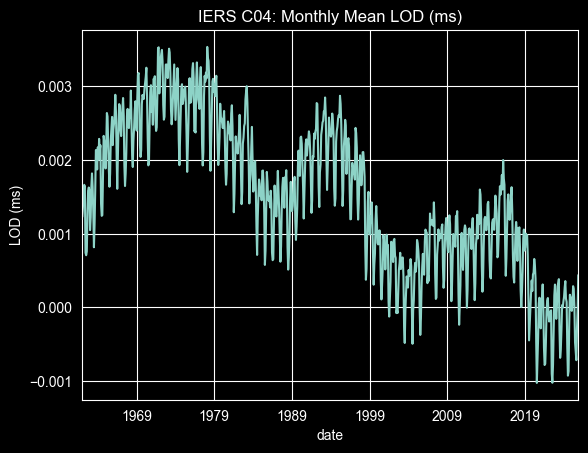

In [3]:
# %%
import matplotlib.pyplot as plt

lod_monthly.plot()
plt.title("IERS C04: Monthly Mean LOD (ms)")
plt.ylabel("LOD (ms)")
plt.show()